# Programming Exercise 7: K-means Clustering and Principal Component Analysis

In [1]:
% matplotlib inline
from math import *

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
# Used to load the OCTAVE *.mat files
from scipy.io import loadmat
# Used for the "SVD" function
from scipy.linalg import svd
# Used to show matrix as an image
from scipy.misc import imread


In [2]:
# Visualizing the data
def plotData(X, centroids_history, indices=None, colors=None, projection=None, draw_history=True):
    """
    Fucntion to plot the data and color it accordingly.
    myidxs should be the latest iteraction index vector
    mycentroids should be a vector of centroids, one per iteration
    """
    if colors is None:
        colors = ['r', 'g', 'b']
    colors_len = len(colors)
    K = centroids_history[0].shape[0]
    dimension = X[0].shape[-1]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection=projection)
    for index in range(K):
        subX = X[np.where(indices == index)]
        ax.scatter(*[subX[:, i] for i in range(dimension)], marker='o', c=colors[index % colors_len], alpha=0.75, label=f'Data Points: Cluster {index}')

    if draw_history:
        #Drawing a history of centroid movement
        tempx, tempy = [], []
        for centroids in centroids_history:
            tempx.append(centroids[:, 0])
            tempy.append(centroids[:, 1])

        for x in range(len(tempx[0])):
            ax.plot(tempx, tempy, 'kx--', markersize=8)


## 1 K-means Clustering

In [3]:
# Read in ex7data2.mac
mat = loadmat('machine-learning-ex7/ex7/ex7data2.mat')
X = mat['X']


In [4]:
# Choose the number of centroids... K = 3
K = 3
# Choose the initial centroids matching ex7.m assignment script
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])


### 1.1 Implementing K-means

#### 1.1.1 Finding closest centroids

$c^{(i)} := j$ that minimizes $\left\|x^{(i)} - \mu_{j}\right\|^{2}$

In [5]:
def findClosestCentroids(X, centroids):
    distances = [np.sum((np.square(X - centroid.reshape(1, -1))), axis=1) for centroid in centroids]
    return np.column_stack(distances).argmin(axis=1)


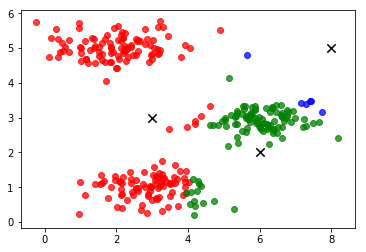

In [6]:
# Find the closest centroids for the examples using the initial_centroids
C = findClosestCentroids(X, initial_centroids)

plotData(X, [initial_centroids], C)


#### 1.1.2 Computing centroid means

$$\mu_{k} := \frac{1}{|C_{k}|}\sum_{i\in C_{k}}x^{(i)}$$

In [7]:
def computeCentroids(X, indices, K):
    return np.row_stack([np.mean(X[np.where(indices == i)[0]], axis=0) for i in range(K)])


In [8]:
computeCentroids(X, C, K)


array([[ 2.42830111,  3.15792418],
       [ 5.81350331,  2.63365645],
       [ 7.11938687,  3.6166844 ]])

### 1.2 K-means on example dataset

In [9]:
def runkMeans(X, initial_centroids, max_iters, plot_progress=None):
    # With initialized centroids
    centroid_history = []
    current_centroids = initial_centroids
    K = len(initial_centroids)
    for i in range(max_iters):
        centroid_history.append(current_centroids)
        # Cluster assignment step: Assign each data point to the
        # closest centroid. idx(i) corresponds to cˆ(i), the index
        # of the centroid assigned to example i
        C = findClosestCentroids(X, current_centroids)

        # Move centroid step: Compute means based on centroid
        # assignments
        current_centroids = computeCentroids(X, C, K)
    if plot_progress is not None:
        plot_progress(X, centroid_history, C)
    return current_centroids, C


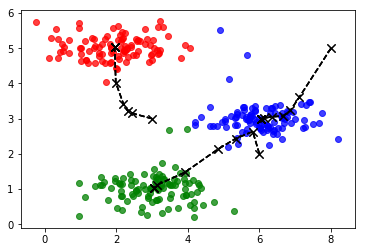

In [10]:
centroids, idx = runkMeans(X, initial_centroids, 10, plotData)


### 1.3 Random initialization

In [11]:
def kMeansInitCentroids(X, K):
    # Initialize the centroids to be random examples
    # Randomly reorder the indices of examples
    # Take the first K examples as centroids
    return X[np.random.choice(np.arange(0, X.shape[0]), size=K, replace=False)]


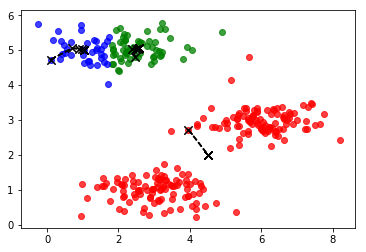

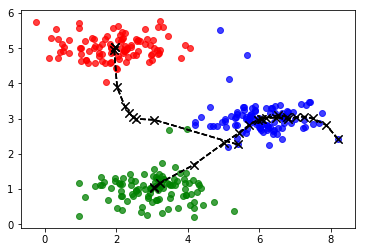

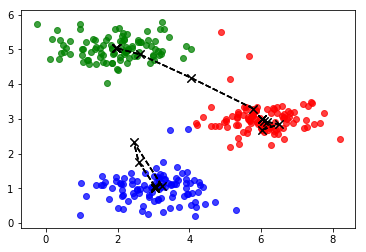

In [12]:
# Let's choose random initial centroids and see the resulting 
# centroid progression plot.. perhaps three times in a row
for x in range(3):
    runkMeans(X, kMeansInitCentroids(X, K=3), 10, plotData)


### 1.4 Image compression with K-means

You will use the K-means algorithm to select the 16 colors that will be used to represent the compressed image.

#### 1.4.1 K-means on pixels

A shape is  (128, 128, 3)


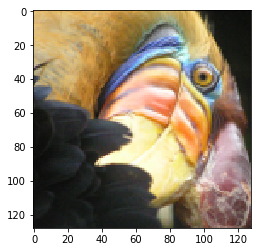

In [13]:
# Load 128x128 color image (birdsmall.png)
A = imread("machine-learning-ex7/ex7/bird_small.png")

#  Loads the image into the variable A
# This creates a three-dimensional matrix A whose first two indices identify 
# a pixel position and whose last index represents red, green, or blue
print("A shape is ", A.shape)
plt.imshow(A)


In [14]:
def compress(image, K, max_iters=10):
    original_shape = image.shape
    figsize = np.array(original_shape[:-1]) // 25
    plt.figure(figsize=figsize)
    plt.imshow(image)
    # Divide by 255 so that all values are in the range 0 - 1
    image = image / 255
    # Reshape the image into an Nx3 matrix where N = number of pixels.
    # Each row will contain the Red, Green and Blue pixel values
    # This gives us our dataset matrix X that we will use K-Means on.
    image = image.reshape((-1, 3))

    # When using K-Means, it is important the initialize the centroids randomly.
    # You should complete the code in kMeansInitCentroids.m before proceeding
    initial_centroids = kMeansInitCentroids(image, K)

    # Run K-Means
    centroids, idx = runkMeans(image, initial_centroids, max_iters)

    # Essentially, now we have represented the image X as in terms of the  indices in idx.
    # We can now recover the image from the indices (idx) by mapping each pixel
    # (specified by its index in idx) to the centroid value
    image_recovered = centroids[idx]
    # Reshape the recovered image into proper dimensions
    image_recovered = image_recovered.reshape(original_shape)

    plt.figure(figsize=figsize)
    plt.imshow(image_recovered)
    return image_recovered, centroids, idx


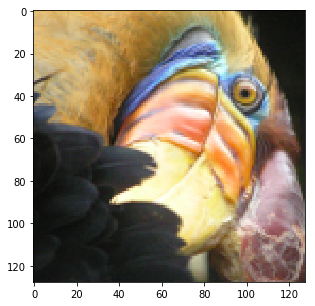

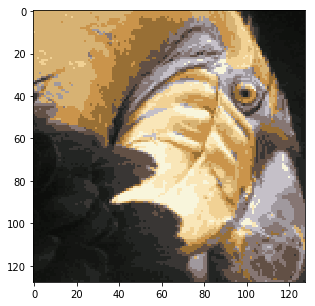

In [15]:
# Run your K-Means algorithm on this data
# You should try different values of K and max_iters here
K = 16
max_iters = 10
image_recovered, centroids, indices = compress(A, K, max_iters)


### 1.5 Optional (ungraded) exercise: Use your own image

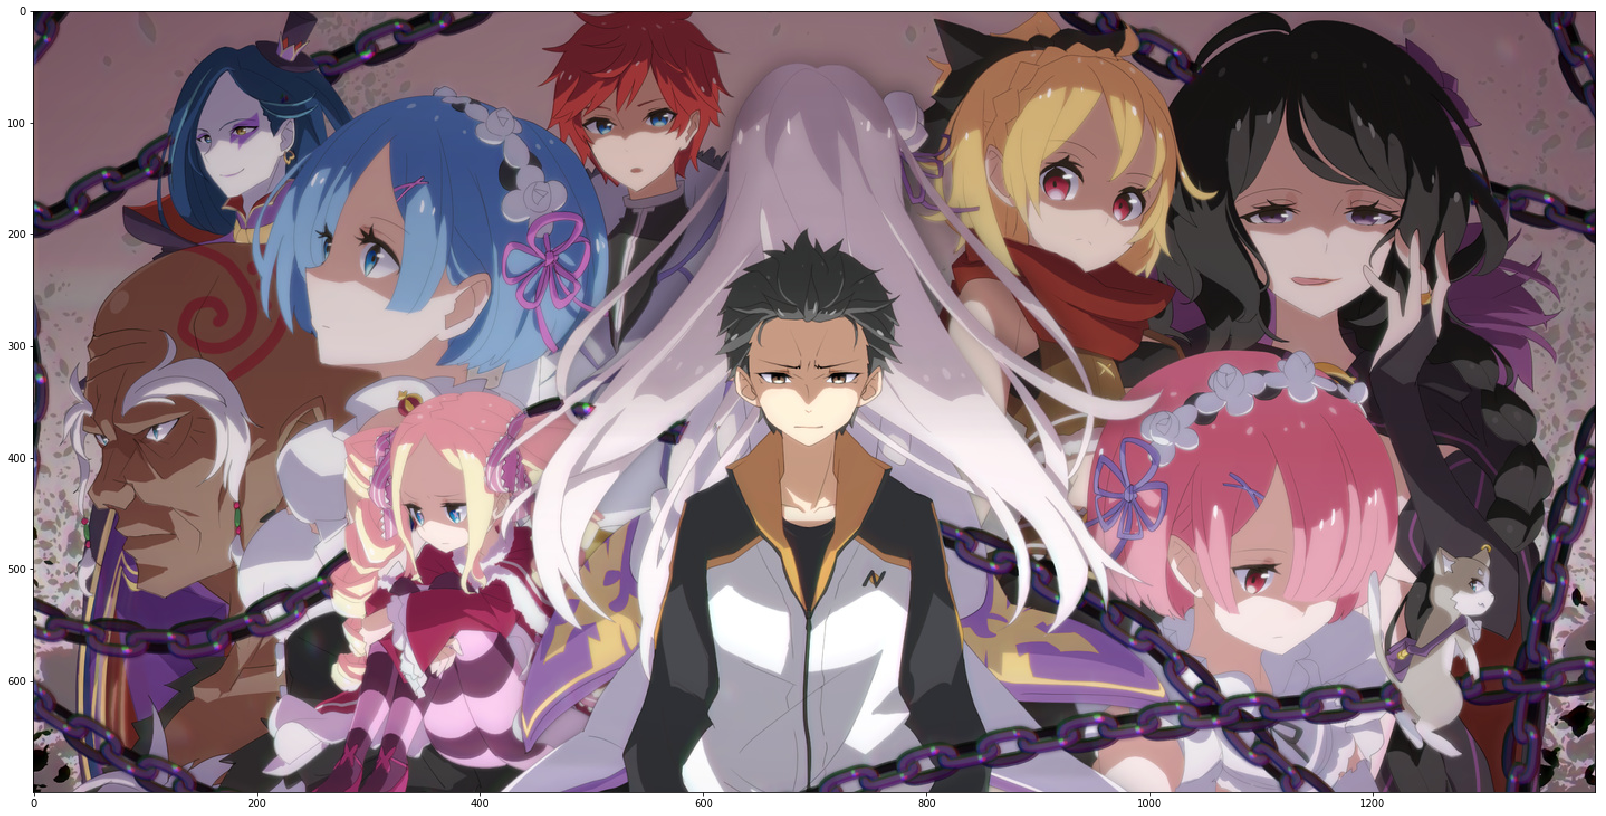

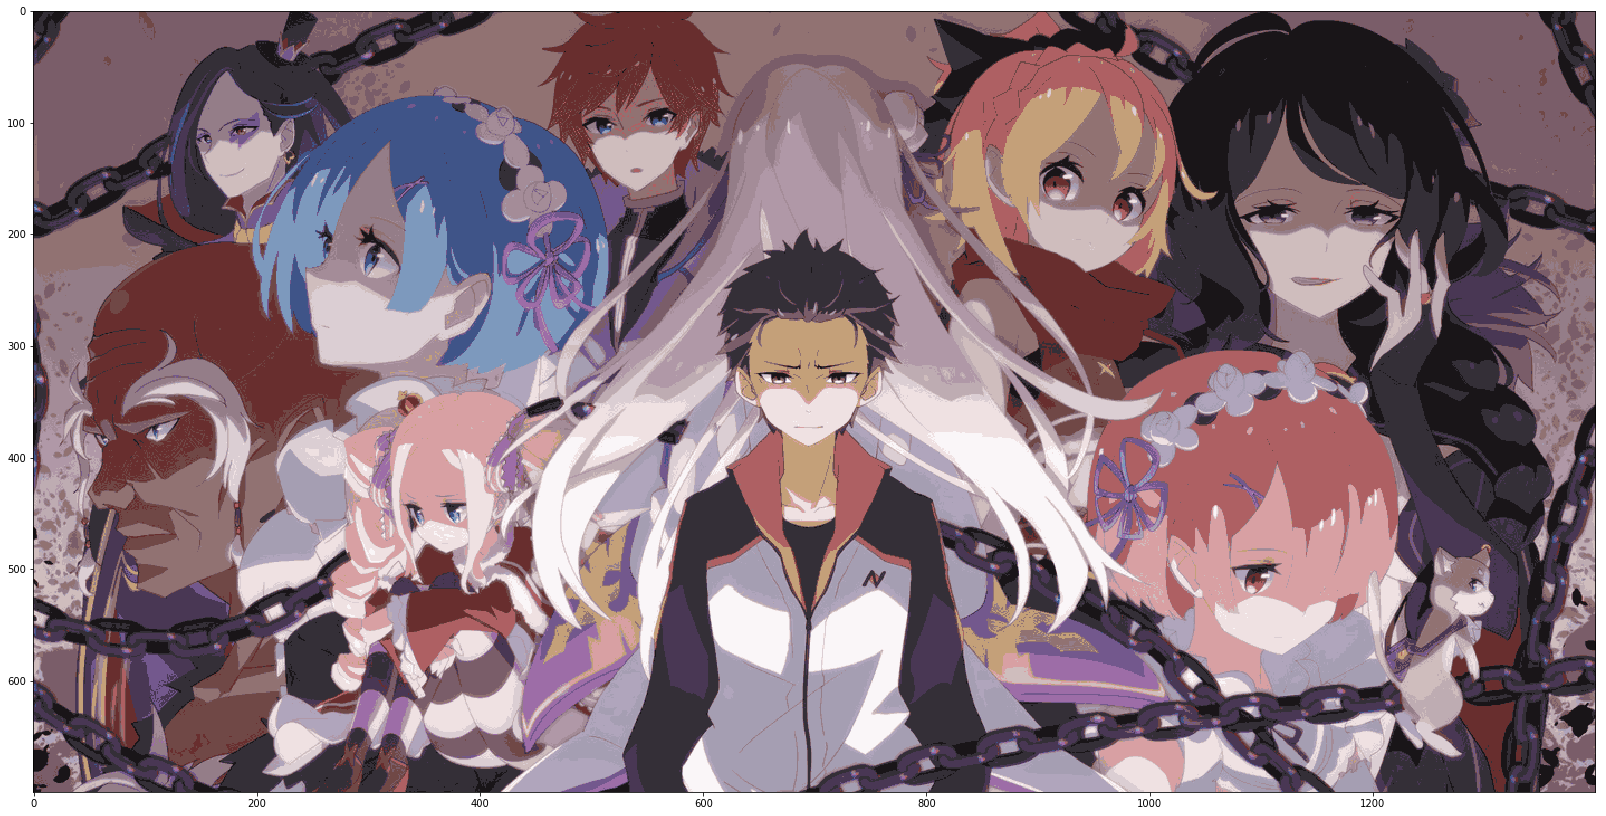

In [16]:
re0 = imread("ReZero.jpg")
compressed_image = compress(re0, 24)[0]


## 2 Principal Component Analysis

### 2.1 Example Dataset

Text(0.5,1,'Example Dataset 1')

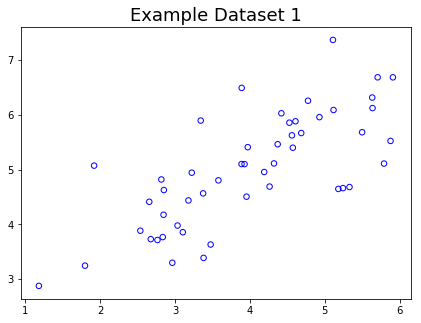

In [17]:
mat = loadmat('machine-learning-ex7/ex7/ex7data1.mat')
X = mat['X']

# Quick plot
plt.figure(figsize=(7, 5))
plot = plt.scatter(X[:, 0], X[:, 1], s=30, facecolors='none', edgecolors='b')
plt.title("Example Dataset 1", fontsize=18)


### 2.2 Implementing PCA

In [18]:
# Before running PCA, it is important to first normalize X
def featureNormalize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    centered_X = (X - mean) / std
    return centered_X, mean, std


In [19]:
def pca(X):
    centered_X, mean, std = featureNormalize(X)
    Sigma = centered_X.T.dot(centered_X) / X.shape[0]
    U, S, V = svd(Sigma)
    return centered_X, U, S, V, mean, std


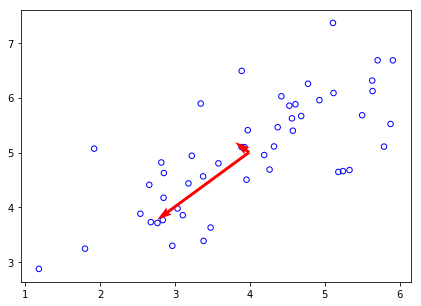

In [20]:
centered_X, U, S, V, mean, std = pca(X)
plt.figure(figsize=(7, 5))
plt.scatter(X[:, 0], X[:, 1], s=30, edgecolors='b', facecolors='None', linewidth=1);
plt.quiver(mean[0], mean[1], U[0, 0], U[0, 1], scale=1 / S[0], color='r', units="xy", scale_units="xy", angles="xy")
plt.quiver(mean[0], mean[1], U[1, 0], U[1, 1], scale=1 / S[1], color='r', units="xy", scale_units="xy", angles="xy")


### 2.3 Dimensionality Reduction with PCA

#### 2.3.1 Projecting the data onto the principal components

$$Z = XU_{reduced}$$

In [21]:
def projectData(X, U, K):
    """
    Function that computes the reduced data representation when
    projecting only on to the top "K" eigenvectors
    """

    # Reduced U is the first "K" columns in U
    Ureduced = U[:, :K]
    Z = X.dot(Ureduced)
    return Z


In [22]:
def dimension_reduce(X, K):
    centered_X, U, *rest = pca(X)
    # Project the data onto K = 1 dimension
    Z = projectData(centered_X, U, K)
    return (Z, centered_X, U, *rest)


In [23]:
Z, *passs = dimension_reduce(X, 1)

# project the first example onto the first dimension, you should see a value of about 1.481
print(Z[0])


[ 1.49631261]


#### 2.3.2 Reconstructing an approximation of the data

$$X_{approx} = ZU_{reduced}^{T}$$

In [24]:
def recoverData(Z, U, K):
    Ureduced = U[:, :K]
    Xapprox = Z.dot(Ureduced.T)
    return Xapprox


In [25]:
X_rec = recoverData(Z, U, 1)
# you will recover an approximation of the first example 
# and you should see a value of about -1.047, -1.047
print('Recovered approximation of the first example is ', X_rec[0])


Recovered approximation of the first example is  [-1.05805279 -1.05805279]


#### 2.3.3 Visualizing the projections

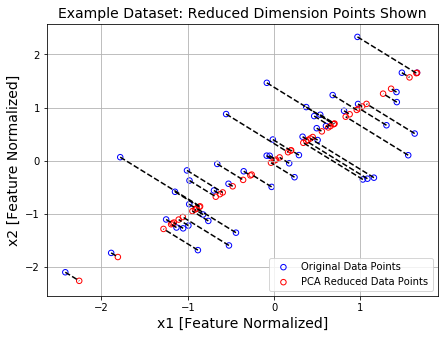

In [26]:
# Quick plot, now drawing projected points to the original points
plt.figure(figsize=(7, 5))
plt.scatter(centered_X[:, 0], centered_X[:, 1], s=30, facecolors='none', edgecolors='b', label='Original Data Points')
plt.scatter(X_rec[:, 0], X_rec[:, 1], s=30, facecolors='none', edgecolors='r', label='PCA Reduced Data Points')

plt.title("Example Dataset: Reduced Dimension Points Shown", fontsize=14)
plt.xlabel('x1 [Feature Normalized]', fontsize=14)
plt.ylabel('x2 [Feature Normalized]', fontsize=14)
plt.grid(True)

for x in range(centered_X.shape[0]):
    plt.plot([centered_X[x, 0], X_rec[x, 0]], [centered_X[x, 1], X_rec[x, 1]], 'k--')

plt.legend(loc=4)


### 2.4 Face Image Dataset

In [27]:
mat = loadmat('machine-learning-ex7/ex7/ex7faces.mat')
X = mat['X']


In [28]:
def displayImageSample(X, nrows=10, ncols=10):
    """
    Function that picks the first 100 rows from X, creates an image from each,
    then stitches them together into a 10x10 grid of images, and shows it.
    """
    width = height = int(sqrt(X.shape[1]))

    X = X[:nrows * ncols]
    big_picture = np.vstack(np.hsplit(X.reshape((-1, height)).T, ncols))
    plt.figure(figsize=(10, 10))
    plt.imshow(big_picture, cmap="gray")


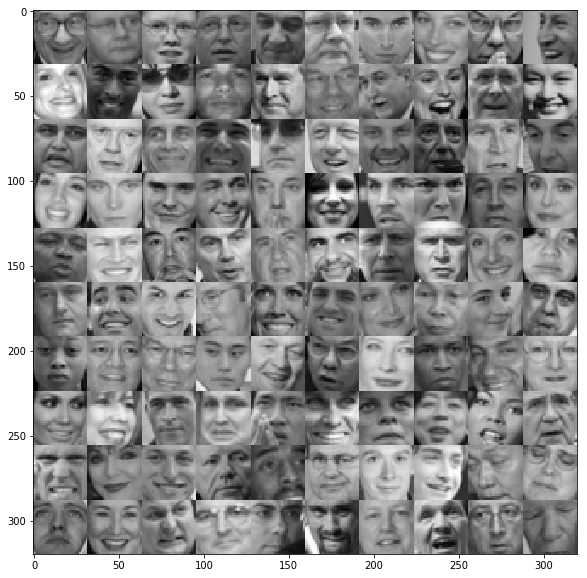

In [29]:
displayImageSample(X)


#### 2.4.1 PCA on Faces

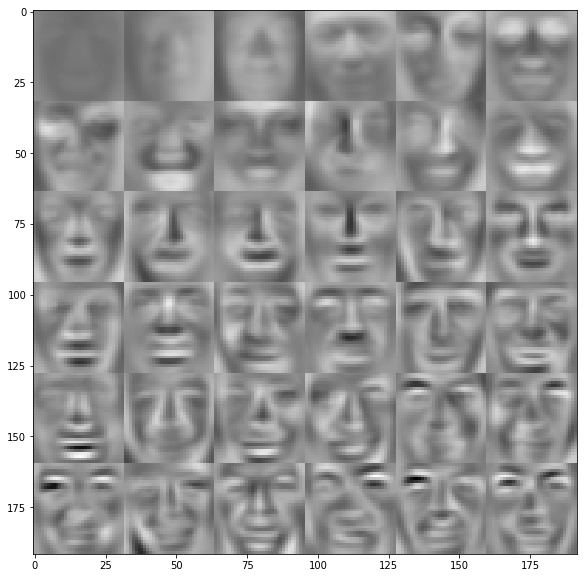

In [30]:
centered_X, U, S, V, mean, std = pca(X)

# displays the first 36 principal components that describe the largest variation
# "Eigenfaces" lol
displayImageSample(U.T, 6, 6)


#### 2.4.2 Dimensionality Reduction

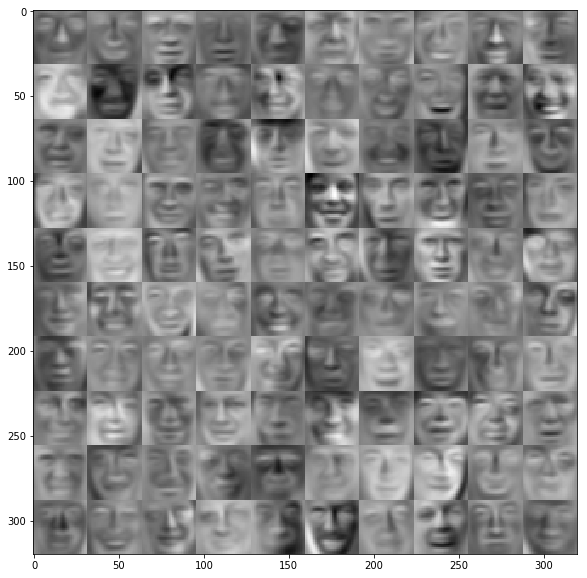

In [31]:
# Project each image down to 36 dimensions
Z = projectData(centered_X, U, K=36)
# Attempt to recover the original data
X_rec = recoverData(Z, U, K=36)
# Plot the dimension-reduced data
displayImageSample(X_rec)


### 2.5 Optional (ungraded) exercise: PCA for visualization

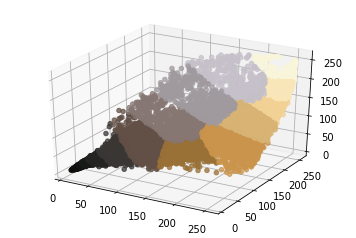

In [32]:
unrolled_A = A.reshape((-1, 3))
plotData(unrolled_A, [centroids], indices=indices, colors=centroids, projection='3d', draw_history=False)


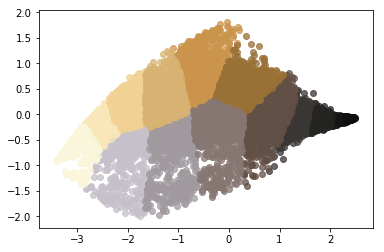

In [33]:
Z, *passs = dimension_reduce(unrolled_A, 2)
plotData(Z, [centroids], indices=indices, colors=centroids, draw_history=False)
